### Import Packages


In [ ]:
import os
import csv
import numpy as np
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

print(torch.__version__)

1.12.1+cu113


### MNIST dataset is provided in default

In [ ]:
train_path = './sample_data/mnist_train_small.csv'
test_path = './sample_data/mnist_test.csv'
img_size = 28

### Choose your device - use GPU or not?

In [ ]:
# device = 'cpu'
device = 'cuda'
print('Current Device : {}'.format(device))

Current Device : cuda


### Read the MNIST dataset
- total 1+ 28x28 dimension. 1 For Label, 28**2 for image


In [ ]:
def mnist_reader(file_path, img_size=img_size):
    total_img = list()
    total_label = list()
    with open(file_path) as csvfile:
        mnist_reader = csv.reader(csvfile)
        for row in tqdm(mnist_reader):
            img = np.array(row[1:], dtype=np.uint16).reshape(img_size, img_size)
            img = img / 255
            label = int(row[0])

            total_img.append(img)
            total_label.append(label)

    total_img = np.asarray(total_img)
    total_label = np.asarray(total_label)
    
    return total_img, total_label

In [ ]:
train_img, train_label = mnist_reader(train_path)
test_img, test_label = mnist_reader(test_path)

# Let's try to reduce the number of data we have.
train_img = train_img[::25]
train_label = train_label[::25]
test_img = test_img[::25]
test_label = test_label[::25]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

### Define the Dataset

In [ ]:
class MNIST_Dataset(Dataset):
    def __init__(self, target_img, target_label):
        self.target_img = target_img
        self.target_label = target_label
        self.num_data = target_img.shape[0]

    def __len__(self):
        return self.num_data

    def __getitem__(self, idx):
        sample = dict()
        sample['img'] = self.target_img[idx]
        sample['label'] = self.target_label[idx]

        return sample

### Define the DataLoader

In [ ]:
batch_size = 256

train_dataset = MNIST_Dataset(train_img, train_label)
test_dataset = MNIST_Dataset(test_img, test_label)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### Try to sample out one data point from dataloader

In [ ]:
sample = next(iter(test_dataloader))
print(sample['img'].shape)
print(sample['label'].shape)

torch.Size([256, 28, 28])
torch.Size([256])


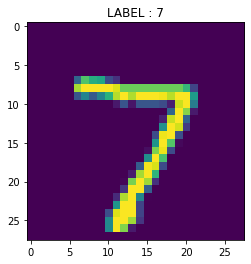

In [ ]:
plot_idx = 0
plt.imshow(sample['img'][plot_idx])
plt.title('LABEL : {}'.format(sample['label'][plot_idx]))
plt.show()

### Define the Multiple Layer Perceptrons

In [ ]:
class MLPs(nn.Module):
    def __init__(self, dim_hidden_1, dim_hidden_2, dim_input=img_size**2, dim_output=10):
        super(MLPs, self).__init__()
        
        self.dim_hidden_1 = dim_hidden_1
        self.dim_hidden_2 = dim_hidden_2
        self.dim_input = dim_input
        self.dim_output = dim_output

        self.layer_1 = nn.Linear(dim_input, dim_hidden_1)
        self.layer_2 = nn.Linear(dim_hidden_1, dim_hidden_2)
        self.layer_3 = nn.Linear(dim_hidden_2, dim_output)

        self.activation = nn.ReLU()
        # self.dropout = nn.Dropout(0.5)

    def forward(self, img):
        batch_size = img.shape[0]
        input = img.view(batch_size, -1)

        # Try to use Dropout after the activation
        hidden_1 = self.activation(self.layer_1(input))
        hidden_2 = self.activation(self.layer_2(hidden_1))
        out = self.layer_3(hidden_2)

        return out

### Define the Model

In [ ]:
model = MLPs(dim_hidden_1=512, dim_hidden_2=256)
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-4)
print(model)

MLPs(
  (layer_1): Linear(in_features=784, out_features=512, bias=True)
  (layer_2): Linear(in_features=512, out_features=256, bias=True)
  (layer_3): Linear(in_features=256, out_features=10, bias=True)
  (activation): ReLU()
)


### Define functions for train/test

In [ ]:
def train(model, optimizer, sample):
    model.train()

    criterion = nn.CrossEntropyLoss()

    optimizer.zero_grad()

    img = sample['img'].float().to(device)
    label = sample['label'].long().to(device) 
    
    pred = model(img)

    num_correct = sum(torch.argmax(pred, dim=1) == label)
    
    pred_loss = criterion(pred, label)
    
    pred_loss.backward()
       
    optimizer.step()

    return pred_loss.item(), num_correct.item()

In [ ]:
def test(model, sample):
    model.eval()

    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        img = sample['img'].float().to(device)
        label = sample['label'].long().to(device) 

        pred = model(img)
        pred_loss = criterion(pred, label)

        num_correct = sum(torch.argmax(pred, dim=1) == label)

    return pred_loss.item(), num_correct.item()

### Run Training

In [ ]:
max_epoch = 200

for epoch in tqdm(range(max_epoch)):        
    ###Train Phase
    
    # Initialize Loss and Accuracy
    train_loss = 0.0
    train_accu = 0.0

    # Iterate over the train_dataloader
    for idx, sample in enumerate(train_dataloader):
        curr_loss, num_correct = train(model, optimizer, sample)
        train_loss += curr_loss / len(train_dataloader)
        train_accu += num_correct / len(train_dataset)

    torch.save(model.state_dict(), 'recent.pth')
    
    ### Test Phase
    # Initialize Loss and Accuracy
    test_loss = 0.0
    test_accu = 0.0

    # Iterate over the test_dataloader
    for idx, sample in enumerate(test_dataloader):
        curr_loss, num_correct = test(model, sample)
        test_loss += curr_loss / len(test_dataloader)
        test_accu += num_correct / len(test_dataset)

    print('[epoch {}] train accu :{:.2f} , test accu :{:.2f}.'.format(epoch+1, train_accu, test_accu))

  0%|          | 0/200 [00:00<?, ?it/s]

[epoch 1] train accu :0.34 , test accu :0.38.
[epoch 2] train accu :0.46 , test accu :0.45.
[epoch 3] train accu :0.55 , test accu :0.53.
[epoch 4] train accu :0.60 , test accu :0.58.
[epoch 5] train accu :0.64 , test accu :0.64.
[epoch 6] train accu :0.66 , test accu :0.64.
[epoch 7] train accu :0.67 , test accu :0.64.
[epoch 8] train accu :0.68 , test accu :0.64.
[epoch 9] train accu :0.69 , test accu :0.65.
[epoch 10] train accu :0.70 , test accu :0.65.
[epoch 11] train accu :0.70 , test accu :0.68.
[epoch 12] train accu :0.72 , test accu :0.72.
[epoch 13] train accu :0.74 , test accu :0.72.
[epoch 14] train accu :0.76 , test accu :0.74.
[epoch 15] train accu :0.77 , test accu :0.75.
[epoch 16] train accu :0.78 , test accu :0.76.
[epoch 17] train accu :0.79 , test accu :0.78.
[epoch 18] train accu :0.80 , test accu :0.78.
[epoch 19] train accu :0.81 , test accu :0.78.
[epoch 20] train accu :0.82 , test accu :0.77.
[epoch 21] train accu :0.83 , test accu :0.79.
[epoch 22] train accu 